# Model Comparison: Random Forest vs CatBoost

## Objective
Compare the performance of Random Forest and CatBoost algorithms for dasymetric poverty mapping in Zamboanga City at both grid-level (1km²) and barangay-level aggregations.

## Comparison Metrics
- **Grid-level**: R², RMSE, MAE on individual 1km² cells
- **Barangay-level**: Aggregated predictions vs actual barangay poverty rates
- **Feature importance**: Which features each model prioritizes
- **Spatial patterns**: Geographic distribution of predictions and errors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("RANDOM FOREST vs CATBOOST COMPARISON")
print("="*80)

RANDOM FOREST vs CATBOOST COMPARISON


## 1. Load Model Outputs

In [2]:
# Define paths
RF_DATA = Path('../output/randomForest/data')
CB_DATA = Path('../output/catBoost/data')
ASSETS = Path('../assets')
OUTPUT = Path('../output/comparison')

# Create output directory
OUTPUT.mkdir(parents=True, exist_ok=True)
(OUTPUT / 'visualizations').mkdir(exist_ok=True)
(OUTPUT / 'tables').mkdir(exist_ok=True)

print("\n📁 Loading model outputs...\n")

# Load Random Forest outputs
try:
    rf_predictions = pd.read_csv(ASSETS / 'grid_with_poverty_predictions.csv')
    print(f"✓ Random Forest predictions: {len(rf_predictions)} grid cells")
    rf_predictions.rename(columns={'poverty_rate_predicted': 'rf_predicted'}, inplace=True)
except FileNotFoundError:
    print("⚠ Random Forest predictions not found in assets folder")
    rf_predictions = None

# Load CatBoost outputs
try:
    cb_predictions = pd.read_csv(CB_DATA / 'catboost_full_grid_predictions.csv')
    print(f"✓ CatBoost predictions: {len(cb_predictions)} grid cells")
    cb_predictions.rename(columns={'poverty_rate_predicted': 'cb_predicted'}, inplace=True)
except FileNotFoundError:
    print("⚠ CatBoost predictions not found")
    cb_predictions = None

# Load feature importances
try:
    rf_importance = pd.read_csv(ASSETS / 'feature_importances.csv')
    rf_importance.rename(columns={'importance': 'rf_importance'}, inplace=True)
    print(f"✓ Random Forest feature importance: {len(rf_importance)} features")
except FileNotFoundError:
    print("⚠ Random Forest feature importance not found")
    rf_importance = None

try:
    cb_importance = pd.read_csv(CB_DATA / 'catboost_feature_importance.csv')
    cb_importance = cb_importance[['feature', 'full_importance']].copy()
    cb_importance.rename(columns={'full_importance': 'cb_importance'}, inplace=True)
    print(f"✓ CatBoost feature importance: {len(cb_importance)} features")
except FileNotFoundError:
    print("⚠ CatBoost feature importance not found")
    cb_importance = None


📁 Loading model outputs...

✓ Random Forest predictions: 1724 grid cells
✓ CatBoost predictions: 1724 grid cells
✓ Random Forest feature importance: 70 features
✓ CatBoost feature importance: 67 features


## 2. Merge Predictions for Comparison

In [3]:
print("\n📊 Merging predictions...\n")

if rf_predictions is not None and cb_predictions is not None:
    # Merge on grid_id
    if 'grid_id' in rf_predictions.columns and 'grid_id' in cb_predictions.columns:
        combined = rf_predictions.merge(
            cb_predictions[['grid_id', 'cb_predicted']], 
            on='grid_id', 
            how='inner'
        )
    else:
        # Merge by index if no grid_id
        combined = rf_predictions.copy()
        combined['cb_predicted'] = cb_predictions['cb_predicted'].values[:len(combined)]
    
    print(f"✓ Combined dataset: {len(combined)} grid cells")
    
    # Filter to cells with actual poverty data (training set)
    if 'poverty_rate' in combined.columns:
        training_cells = combined[combined['poverty_rate'].notna()].copy()
        print(f"✓ Training cells (with actual data): {len(training_cells)}")
        
        # Calculate errors
        training_cells['rf_error'] = abs(training_cells['poverty_rate'] - training_cells['rf_predicted'])
        training_cells['cb_error'] = abs(training_cells['poverty_rate'] - training_cells['cb_predicted'])
        training_cells['error_diff'] = training_cells['cb_error'] - training_cells['rf_error']
        
        print(f"\n📈 Grid-Level Performance Summary:")
        print(f"\nRandom Forest:")
        print(f"  Mean prediction: {training_cells['rf_predicted'].mean():.4f}")
        print(f"  Mean absolute error: {training_cells['rf_error'].mean():.4f}")
        print(f"  R²: {r2_score(training_cells['poverty_rate'], training_cells['rf_predicted']):.4f}")
        
        print(f"\nCatBoost:")
        print(f"  Mean prediction: {training_cells['cb_predicted'].mean():.4f}")
        print(f"  Mean absolute error: {training_cells['cb_error'].mean():.4f}")
        print(f"  R²: {r2_score(training_cells['poverty_rate'], training_cells['cb_predicted']):.4f}")
    else:
        training_cells = combined
        print("⚠ No actual poverty data available for validation")
else:
    print("❌ Cannot create comparison - missing prediction files")
    combined = None
    training_cells = None


📊 Merging predictions...

✓ Combined dataset: 1724 grid cells
✓ Training cells (with actual data): 1724

📈 Grid-Level Performance Summary:

Random Forest:
  Mean prediction: 0.5038
  Mean absolute error: 0.0344
  R²: 0.7958

CatBoost:
  Mean prediction: 0.4984
  Mean absolute error: 0.0014
  R²: 0.9995


## 3. Grid-Level Metrics Comparison

In [ ]:
if training_cells is not None and 'poverty_rate' in training_cells.columns:
    print("\n" + "="*80)
    print("GRID-LEVEL METRICS COMPARISON (1km² cells)")
    print("="*80 + "\n")
    
    # Calculate metrics
    metrics = {
        'Model': ['Random Forest', 'CatBoost'],
        'R²': [
            r2_score(training_cells['poverty_rate'], training_cells['rf_predicted']),
            r2_score(training_cells['poverty_rate'], training_cells['cb_predicted'])
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(training_cells['poverty_rate'], training_cells['rf_predicted'])),
            np.sqrt(mean_squared_error(training_cells['poverty_rate'], training_cells['cb_predicted']))
        ],
        'MAE': [
            mean_absolute_error(training_cells['poverty_rate'], training_cells['rf_predicted']),
            mean_absolute_error(training_cells['poverty_rate'], training_cells['cb_predicted'])
        ]
    }
    
    metrics_df = pd.DataFrame(metrics)
    print("\n" + metrics_df.to_string(index=False))
    
    # Save metrics
    metrics_df.to_csv(OUTPUT / 'tables' / 'grid_level_metrics.csv', index=False)
    print(f"\n✓ Saved to {OUTPUT / 'tables' / 'grid_level_metrics.csv'}")
    
    # Winner
    if metrics_df.loc[0, 'R²'] > metrics_df.loc[1, 'R²']:
        print(f"\n🏆 Grid-level winner: Random Forest (R² = {metrics_df.loc[0, 'R²']:.4f})")
    else:
        print(f"\n🏆 Grid-level winner: CatBoost (R² = {metrics_df.loc[1, 'R²']:.4f})")


GRID-LEVEL METRICS COMPARISON (1km² cells)

        Model       R²     RMSE      MAE
Random Forest 0.795818 0.045282 0.034371
     CatBoost 0.999505 0.002230 0.001397

✓ Saved to ..\output\comparison\tables\grid_level_metrics.csv

🏆 Grid-level winner: CatBoost (R² = 0.9995)


## 4. Barangay-Level Aggregation and Comparison

In [ ]:
if combined is not None and 'barangay_name' in combined.columns:
    print("\n" + "="*80)
    print("BARANGAY-LEVEL METRICS COMPARISON (Aggregated from grid)")
    print("="*80 + "\n")
    
    # Use barangay_name_clean if available, otherwise barangay_name
    brgy_col = 'barangay_name_clean' if 'barangay_name_clean' in combined.columns else 'barangay_name'
    
    # Aggregate to barangay level (mean of grid cells)
    barangay_agg = combined.groupby(brgy_col).agg({
        'poverty_rate': 'mean',
        'rf_predicted': 'mean',
        'cb_predicted': 'mean'
    }).reset_index()
    
    # Filter to barangays with actual poverty data
    barangay_agg = barangay_agg[barangay_agg['poverty_rate'].notna()].copy()
    
    print(f"\n✓ Aggregated to {len(barangay_agg)} barangays")
    
    # Calculate barangay-level metrics
    barangay_metrics = {
        'Model': ['Random Forest', 'CatBoost'],
        'R²': [
            r2_score(barangay_agg['poverty_rate'], barangay_agg['rf_predicted']),
            r2_score(barangay_agg['poverty_rate'], barangay_agg['cb_predicted'])
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(barangay_agg['poverty_rate'], barangay_agg['rf_predicted'])),
            np.sqrt(mean_squared_error(barangay_agg['poverty_rate'], barangay_agg['cb_predicted']))
        ],
        'MAE': [
            mean_absolute_error(barangay_agg['poverty_rate'], barangay_agg['rf_predicted']),
            mean_absolute_error(barangay_agg['poverty_rate'], barangay_agg['cb_predicted'])
        ]
    }
    
    barangay_metrics_df = pd.DataFrame(barangay_metrics)
    print("\n" + barangay_metrics_df.to_string(index=False))
    
    # Save metrics
    barangay_metrics_df.to_csv(OUTPUT / 'tables' / 'barangay_level_metrics.csv', index=False)
    print(f"\n✓ Saved to {OUTPUT / 'tables' / 'barangay_level_metrics.csv'}")
    
    # Winner
    if barangay_metrics_df.loc[0, 'R²'] > barangay_metrics_df.loc[1, 'R²']:
        print(f"\n🏆 Barangay-level winner: Random Forest (R² = {barangay_metrics_df.loc[0, 'R²']:.4f})")
    else:
        print(f"\n🏆 Barangay-level winner: CatBoost (R² = {barangay_metrics_df.loc[1, 'R²']:.4f})")
else:
    print("\n⚠ Cannot perform barangay-level aggregation (missing barangay_name column)")
    barangay_agg = None


⚠ Cannot perform barangay-level aggregation (missing barangay_name column)


## 5. Feature Importance Comparison

In [ ]:
if rf_importance is not None and cb_importance is not None:
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE COMPARISON")
    print("="*80 + "\n")
    
    # Merge feature importances
    importance_comp = rf_importance.merge(cb_importance, on='feature', how='outer')
    importance_comp.fillna(0, inplace=True)
    
    # Normalize to 0-100 scale
    if importance_comp['rf_importance'].max() > 0:
        importance_comp['rf_importance_norm'] = (importance_comp['rf_importance'] / 
                                                 importance_comp['rf_importance'].max() * 100)
    if importance_comp['cb_importance'].max() > 0:
        importance_comp['cb_importance_norm'] = (importance_comp['cb_importance'] / 
                                                 importance_comp['cb_importance'].max() * 100)
    
    # Calculate difference
    importance_comp['importance_diff'] = (importance_comp['cb_importance_norm'] - 
                                          importance_comp['rf_importance_norm'])
    
    # Top 20 features by average importance
    importance_comp['avg_importance'] = (importance_comp['rf_importance_norm'] + 
                                         importance_comp['cb_importance_norm']) / 2
    top_features = importance_comp.nlargest(20, 'avg_importance')
    
    print("\nTop 20 Features (by average importance):")
    print(top_features[['feature', 'rf_importance_norm', 'cb_importance_norm']].to_string(index=False))
    
    # Save
    importance_comp.to_csv(OUTPUT / 'tables' / 'feature_importance_comparison.csv', index=False)
    print(f"\n✓ Saved to {OUTPUT / 'tables' / 'feature_importance_comparison.csv'}")
else:
    print("\n⚠ Cannot compare feature importance (missing files)")
    importance_comp = None


FEATURE IMPORTANCE COMPARISON

Top 20 Features (by average importance):
                      feature  rf_importance_norm  cb_importance_norm
             no_education_pct           51.144575          100.000000
          service_workers_pct          100.000000           50.990996
             farm_workers_pct           23.489397           15.730411
    Children Attending School           14.060373           14.491459
               highschool_pct            6.647699           19.586205
          self_employed_count            5.195699           18.840003
               elementary_pct            6.392461           16.893805
              strong_roof_pct            0.467731           20.400704
Children Not Attending School            6.442682           12.721596
      seasonal_employment_pct            0.692969           16.834674
                  college_pct            0.598890           16.804878
        unskilled_workers_pct            0.422168           15.170863
             sing

## 6. Visualization: Performance Comparison


✓ Saved grid-level comparison plot to ..\output\comparison\visualizations\grid_level_comparison.png


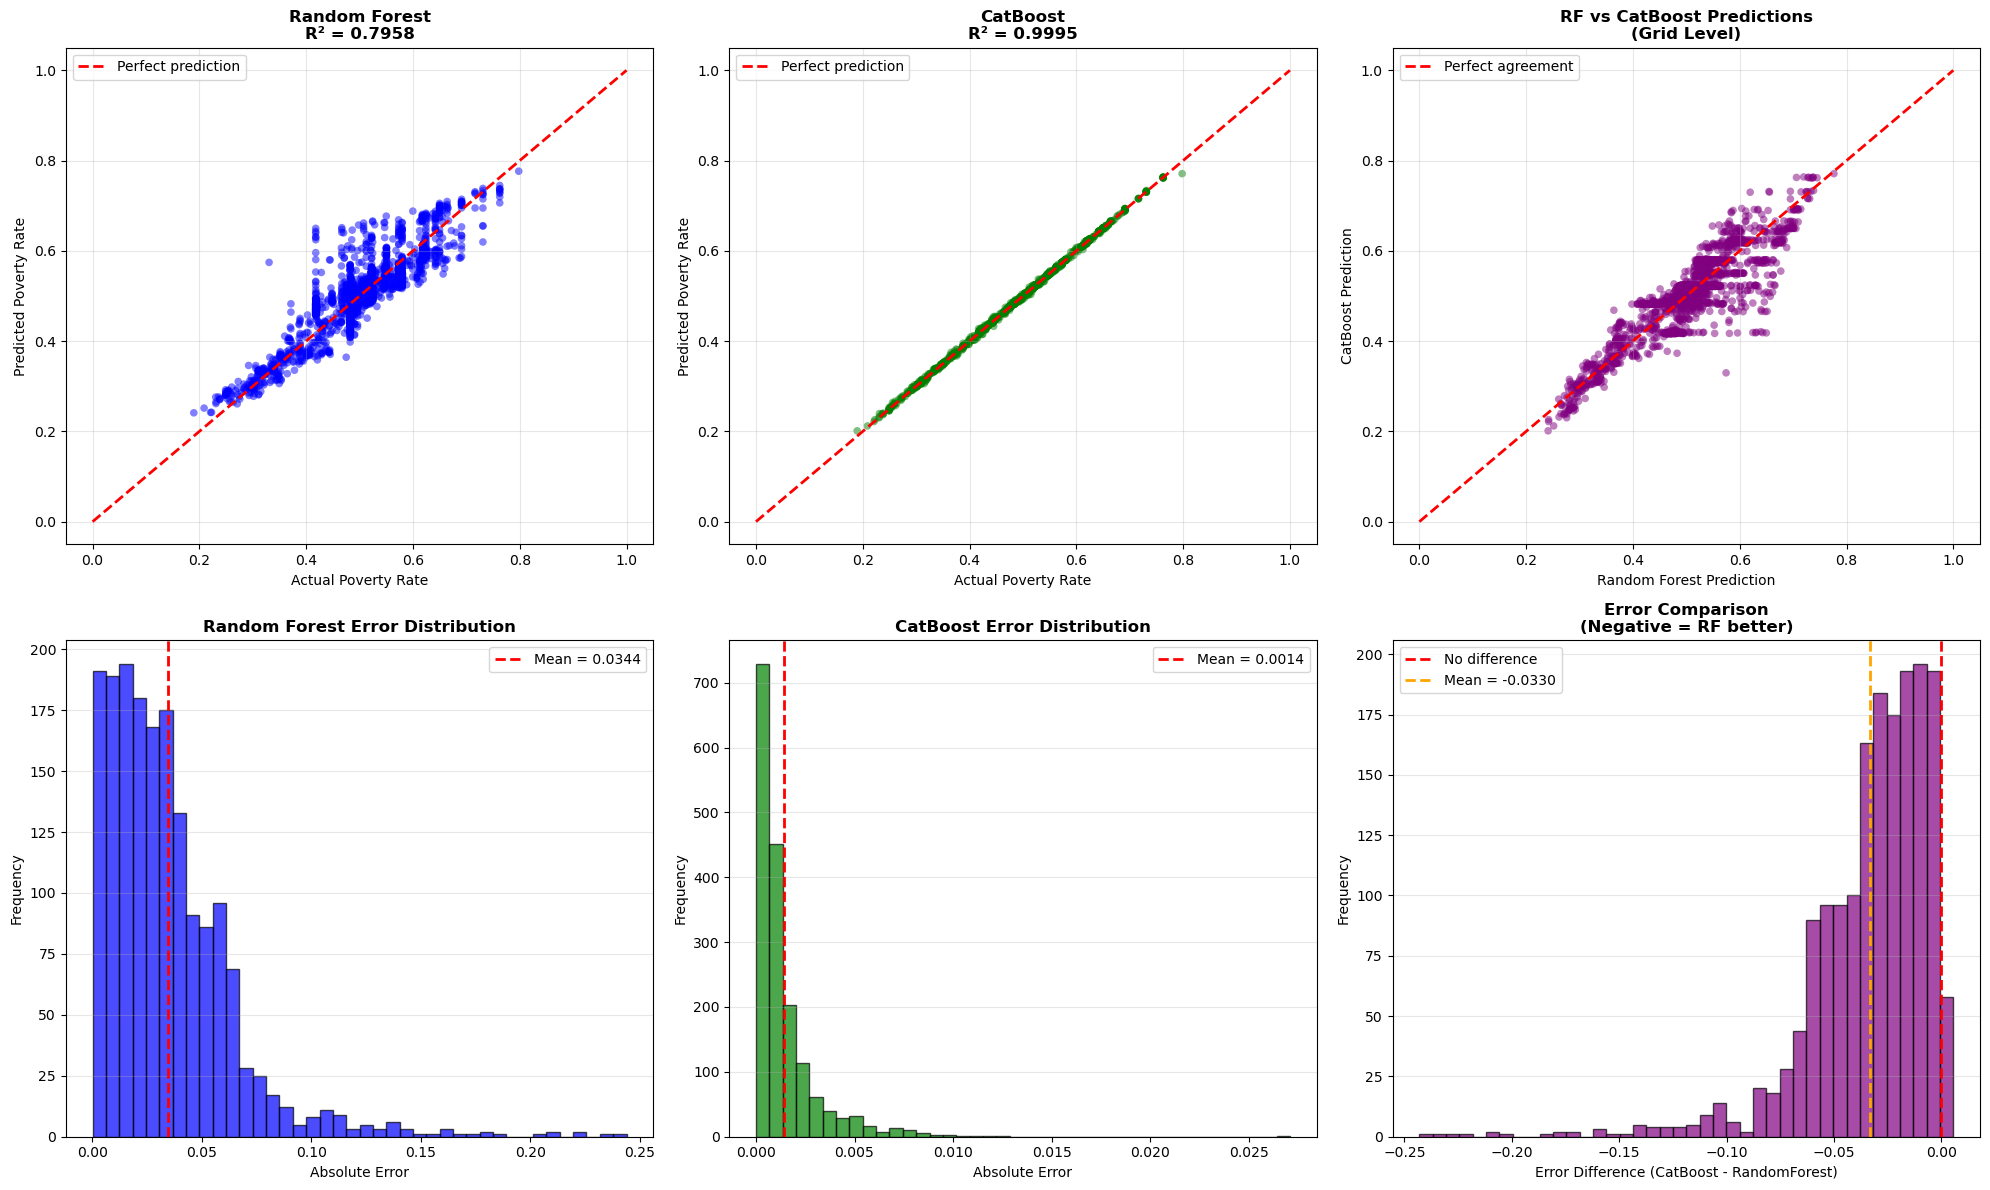

In [ ]:
if training_cells is not None and 'poverty_rate' in training_cells.columns:
    fig, axes = plt.subplots(2, 3, figsize=(22, 13))
    
    # ========================================================================
    # 1. Predicted vs Actual - Random Forest
    # ========================================================================
    ax1 = axes[0, 0]
    ax1.scatter(training_cells['poverty_rate'], training_cells['rf_predicted'], 
               alpha=0.5, s=30, edgecolors='none', c='blue')
    ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
    ax1.set_xlabel('Actual Poverty Rate')
    ax1.set_ylabel('Predicted Poverty Rate')
    ax1.set_title(f'Random Forest\nR² = {r2_score(training_cells["poverty_rate"], training_cells["rf_predicted"]):.4f}', 
                 fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ========================================================================
    # 2. Predicted vs Actual - CatBoost
    # ========================================================================
    ax2 = axes[0, 1]
    ax2.scatter(training_cells['poverty_rate'], training_cells['cb_predicted'], 
               alpha=0.5, s=30, edgecolors='none', c='green')
    ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
    ax2.set_xlabel('Actual Poverty Rate')
    ax2.set_ylabel('Predicted Poverty Rate')
    ax2.set_title(f'CatBoost\nR² = {r2_score(training_cells["poverty_rate"], training_cells["cb_predicted"]):.4f}', 
                 fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ========================================================================
    # 3. Direct Comparison
    # ========================================================================
    ax3 = axes[0, 2]
    ax3.scatter(training_cells['rf_predicted'], training_cells['cb_predicted'], 
               alpha=0.5, s=30, edgecolors='none', c='purple')
    ax3.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect agreement')
    ax3.set_xlabel('Random Forest Prediction')
    ax3.set_ylabel('CatBoost Prediction')
    ax3.set_title('RF vs CatBoost Predictions\n(Grid Level)', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # ========================================================================
    # 4. Error Distribution - RF
    # ========================================================================
    ax4 = axes[1, 0]
    ax4.hist(training_cells['rf_error'], bins=40, alpha=0.7, color='blue', edgecolor='black')
    ax4.axvline(training_cells['rf_error'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean = {training_cells["rf_error"].mean():.4f}')
    ax4.set_xlabel('Absolute Error')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Random Forest Error Distribution', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================
    # 5. Error Distribution - CatBoost
    # ========================================================================
    ax5 = axes[1, 1]
    ax5.hist(training_cells['cb_error'], bins=40, alpha=0.7, color='green', edgecolor='black')
    ax5.axvline(training_cells['cb_error'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean = {training_cells["cb_error"].mean():.4f}')
    ax5.set_xlabel('Absolute Error')
    ax5.set_ylabel('Frequency')
    ax5.set_title('CatBoost Error Distribution', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # ========================================================================
    # 6. Error Difference (CB - RF)
    # ========================================================================
    ax6 = axes[1, 2]
    ax6.hist(training_cells['error_diff'], bins=40, alpha=0.7, color='purple', edgecolor='black')
    ax6.axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
    ax6.axvline(training_cells['error_diff'].mean(), color='orange', linestyle='--', 
               linewidth=2, label=f'Mean = {training_cells["error_diff"].mean():.4f}')
    ax6.set_xlabel('Error Difference (CatBoost - RandomForest)')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Error Comparison\n(Negative = RF better)', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout(pad=2.0)
    plt.savefig(OUTPUT / 'visualizations' / 'grid_level_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved grid-level comparison plot to {OUTPUT / 'visualizations' / 'grid_level_comparison.png'}\n")
    plt.show()

## 7. Visualization: Feature Importance Comparison


✓ Saved feature importance plot to ..\output\comparison\visualizations\feature_importance_comparison.png


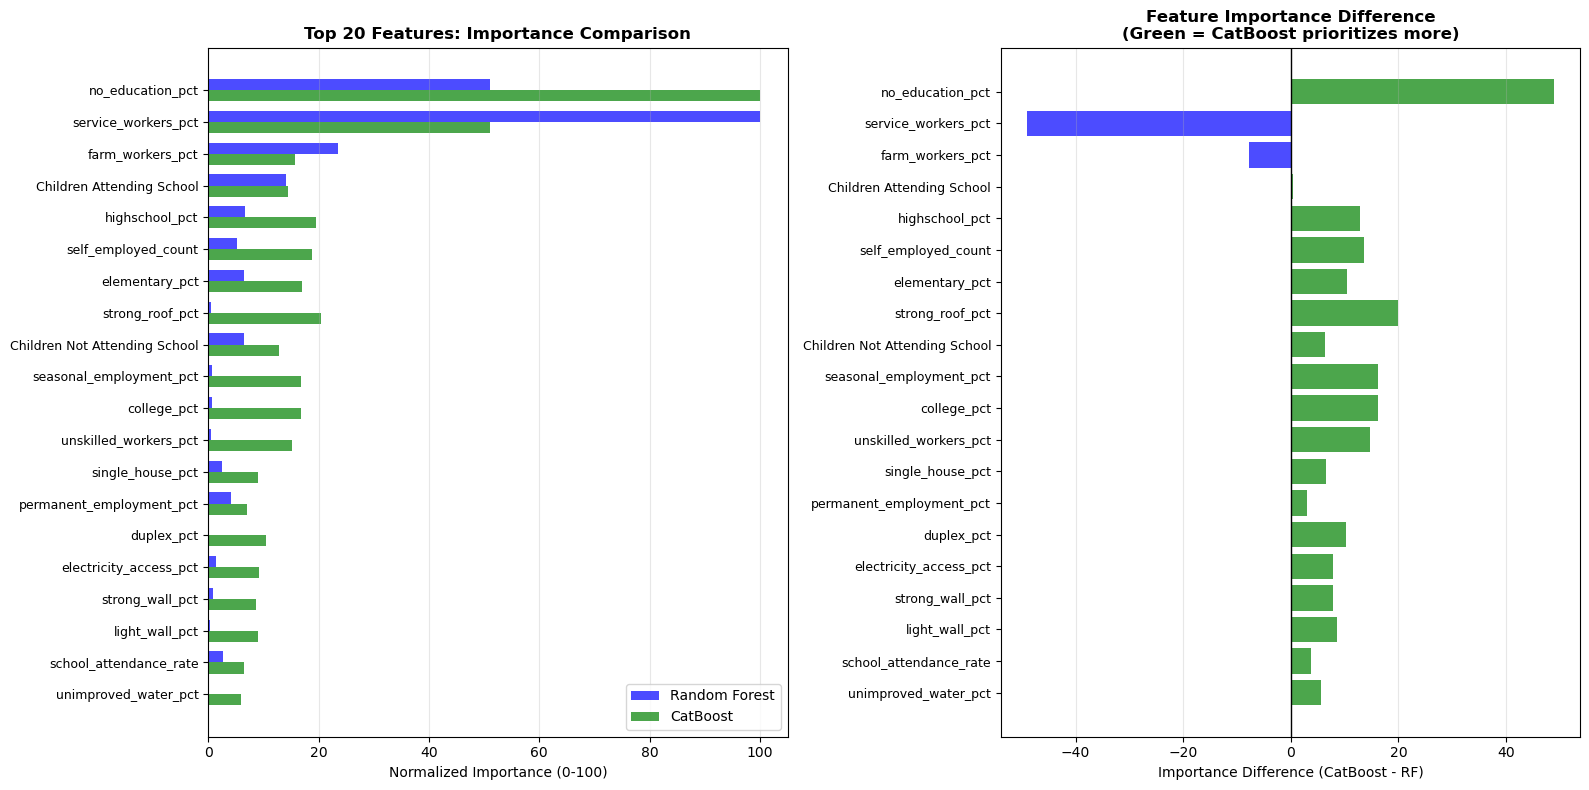

In [ ]:
if importance_comp is not None:
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    
    # Top 20 features side by side
    top_20 = importance_comp.nlargest(20, 'avg_importance').copy()
    
    # ========================================================================
    # 1. Side-by-side bar plot
    # ========================================================================
    ax1 = axes[0]
    x = np.arange(len(top_20))
    width = 0.35
    
    ax1.barh(x - width/2, top_20['rf_importance_norm'], width, label='Random Forest', color='blue', alpha=0.7)
    ax1.barh(x + width/2, top_20['cb_importance_norm'], width, label='CatBoost', color='green', alpha=0.7)
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(top_20['feature'], fontsize=9)
    ax1.set_xlabel('Normalized Importance (0-100)')
    ax1.set_title('Top 20 Features: Importance Comparison', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # ========================================================================
    # 2. Importance difference
    # ========================================================================
    ax2 = axes[1]
    colors_diff = ['green' if x > 0 else 'blue' for x in top_20['importance_diff']]
    ax2.barh(range(len(top_20)), top_20['importance_diff'], color=colors_diff, alpha=0.7)
    ax2.axvline(0, color='black', linestyle='-', linewidth=1)
    ax2.set_yticks(range(len(top_20)))
    ax2.set_yticklabels(top_20['feature'], fontsize=9)
    ax2.set_xlabel('Importance Difference (CatBoost - RF)')
    ax2.set_title('Feature Importance Difference\n(Green = CatBoost prioritizes more)', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.invert_yaxis()
    
    plt.tight_layout(pad=2.0)
    plt.savefig(OUTPUT / 'visualizations' / 'feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved feature importance plot to {OUTPUT / 'visualizations' / 'feature_importance_comparison.png'}\n")
    plt.show()

## 8. Visualization: Barangay-Level Comparison

In [ ]:
if barangay_agg is not None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # ========================================================================
    # 1. Random Forest - Barangay Level
    # ========================================================================
    ax1 = axes[0]
    ax1.scatter(barangay_agg['poverty_rate'], barangay_agg['rf_predicted'], 
               alpha=0.6, s=100, edgecolors='black', linewidth=0.5, c='blue')
    ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
    ax1.set_xlabel('Actual Poverty Rate (Barangay)')
    ax1.set_ylabel('Predicted Poverty Rate')
    ax1.set_title(f'Random Forest (Barangay Level)\nR² = {r2_score(barangay_agg["poverty_rate"], barangay_agg["rf_predicted"]):.4f}', 
                 fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ========================================================================
    # 2. CatBoost - Barangay Level
    # ========================================================================
    ax2 = axes[1]
    ax2.scatter(barangay_agg['poverty_rate'], barangay_agg['cb_predicted'], 
               alpha=0.6, s=100, edgecolors='black', linewidth=0.5, c='green')
    ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
    ax2.set_xlabel('Actual Poverty Rate (Barangay)')
    ax2.set_ylabel('Predicted Poverty Rate')
    ax2.set_title(f'CatBoost (Barangay Level)\nR² = {r2_score(barangay_agg["poverty_rate"], barangay_agg["cb_predicted"]):.4f}', 
                 fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ========================================================================
    # 3. Direct Comparison
    # ========================================================================
    ax3 = axes[2]
    ax3.scatter(barangay_agg['rf_predicted'], barangay_agg['cb_predicted'], 
               alpha=0.6, s=100, edgecolors='black', linewidth=0.5, c='purple')
    ax3.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect agreement')
    ax3.set_xlabel('Random Forest Prediction')
    ax3.set_ylabel('CatBoost Prediction')
    ax3.set_title(f'RF vs CatBoost\n(Barangay Level, n={len(barangay_agg)})', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout(pad=2.0)
    plt.savefig(OUTPUT / 'visualizations' / 'barangay_level_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved barangay-level comparison plot to {OUTPUT / 'visualizations' / 'barangay_level_comparison.png'}\n")
    plt.show()

## 9. Summary Report

In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80 + "\n")

print("📊 Outputs saved to:") 
print(f"  Tables: {OUTPUT / 'tables'}")
print(f"  Visualizations: {OUTPUT / 'visualizations'}")

print("\n📁 Files created:")
for file in (OUTPUT / 'tables').glob('*.csv'):
    print(f"  - {file.name}")
for file in (OUTPUT / 'visualizations').glob('*.png'):
    print(f"  - {file.name}")

print("\n" + "="*80)
print("COMPARISON COMPLETE")
print("="*80 + "\n")


FINAL SUMMARY

📊 Outputs saved to:
  Tables: ..\output\comparison\tables
  Visualizations: ..\output\comparison\visualizations

📁 Files created:
  - feature_importance_comparison.csv
  - grid_level_metrics.csv
  - feature_importance_comparison.png
  - grid_level_comparison.png

COMPARISON COMPLETE


## 10. Side-by-Side Spatial Comparison Maps


CREATING SPATIAL COMPARISON MAPS

✓ Loading grid geometry from ..\assets\grid_with_comprehensive_data.geojson
✓ Merged predictions with 1724 grid cells

✓ Saved to ..\output\comparison\visualizations\spatial_predictions_comparison.png


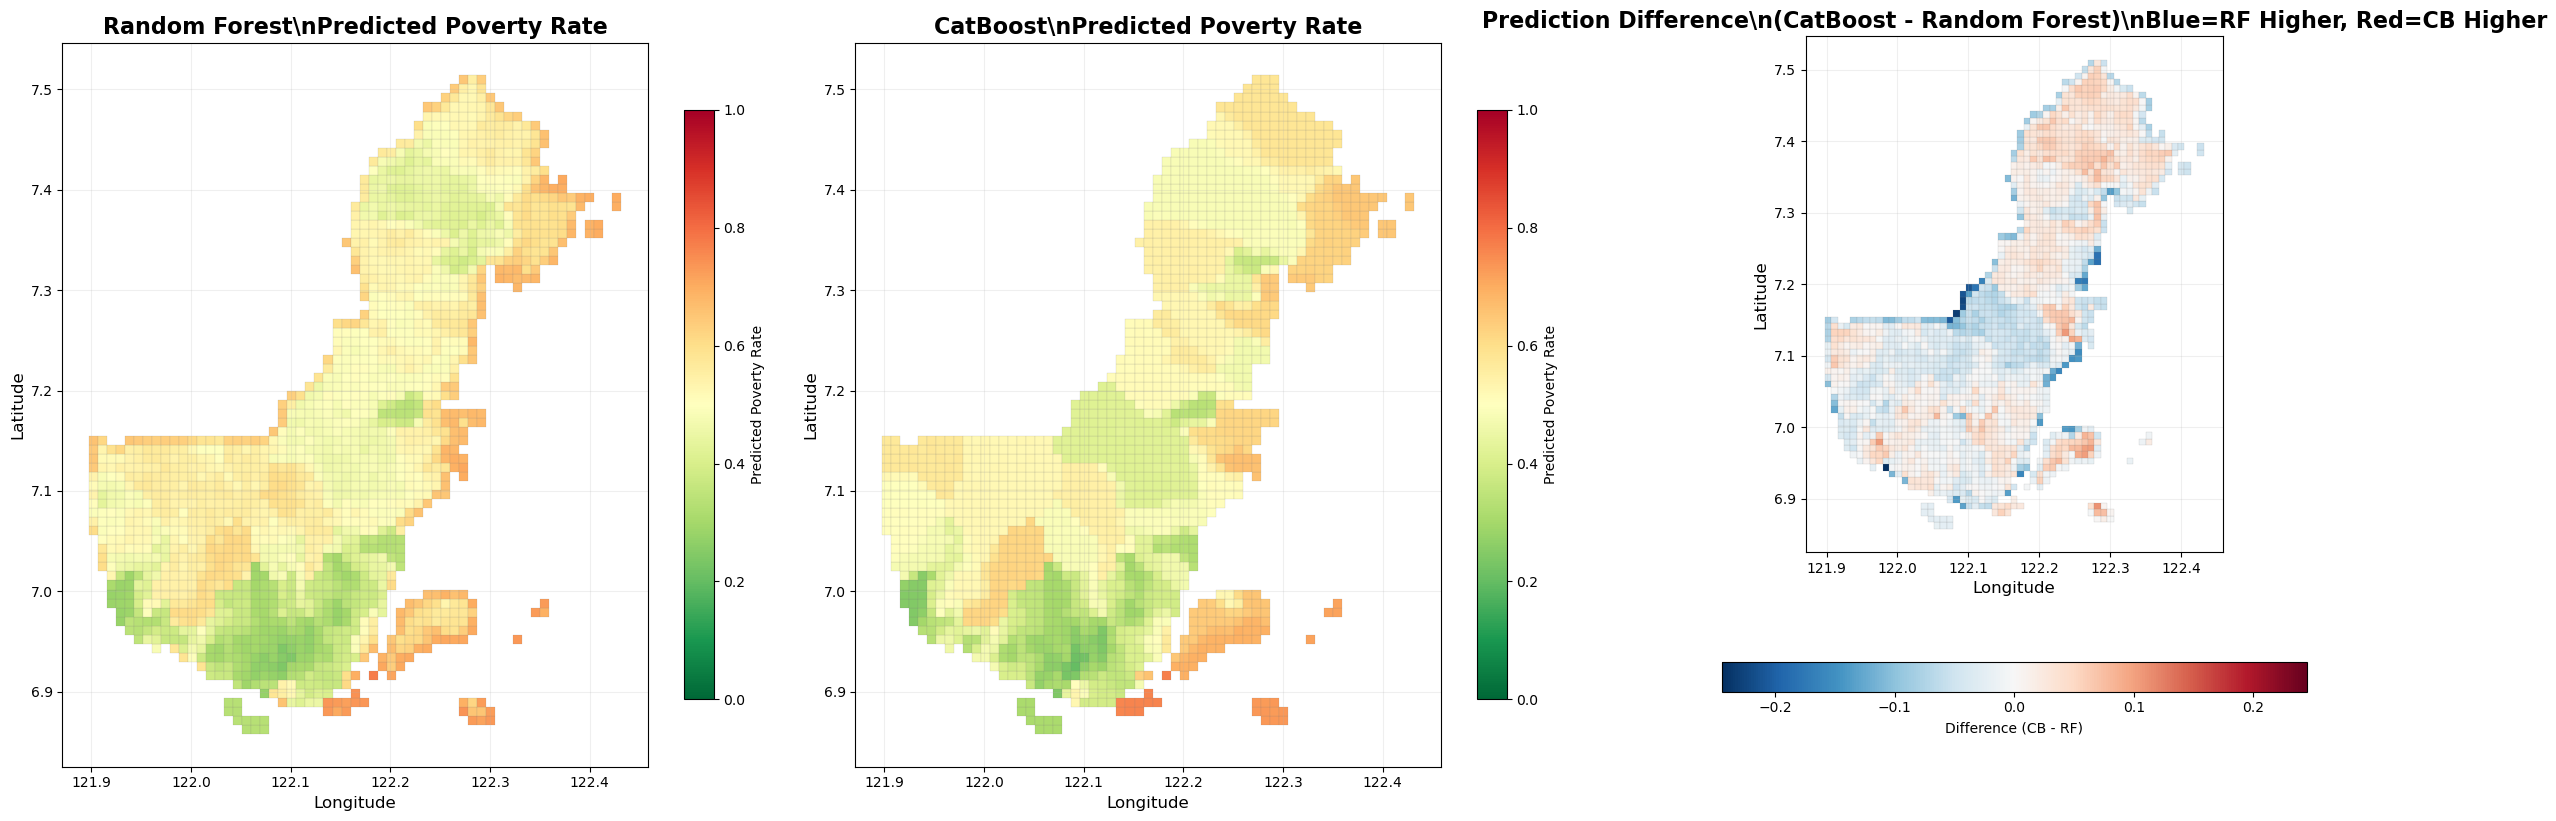

✓ Saved to ..\output\comparison\visualizations\spatial_classification_comparison.png


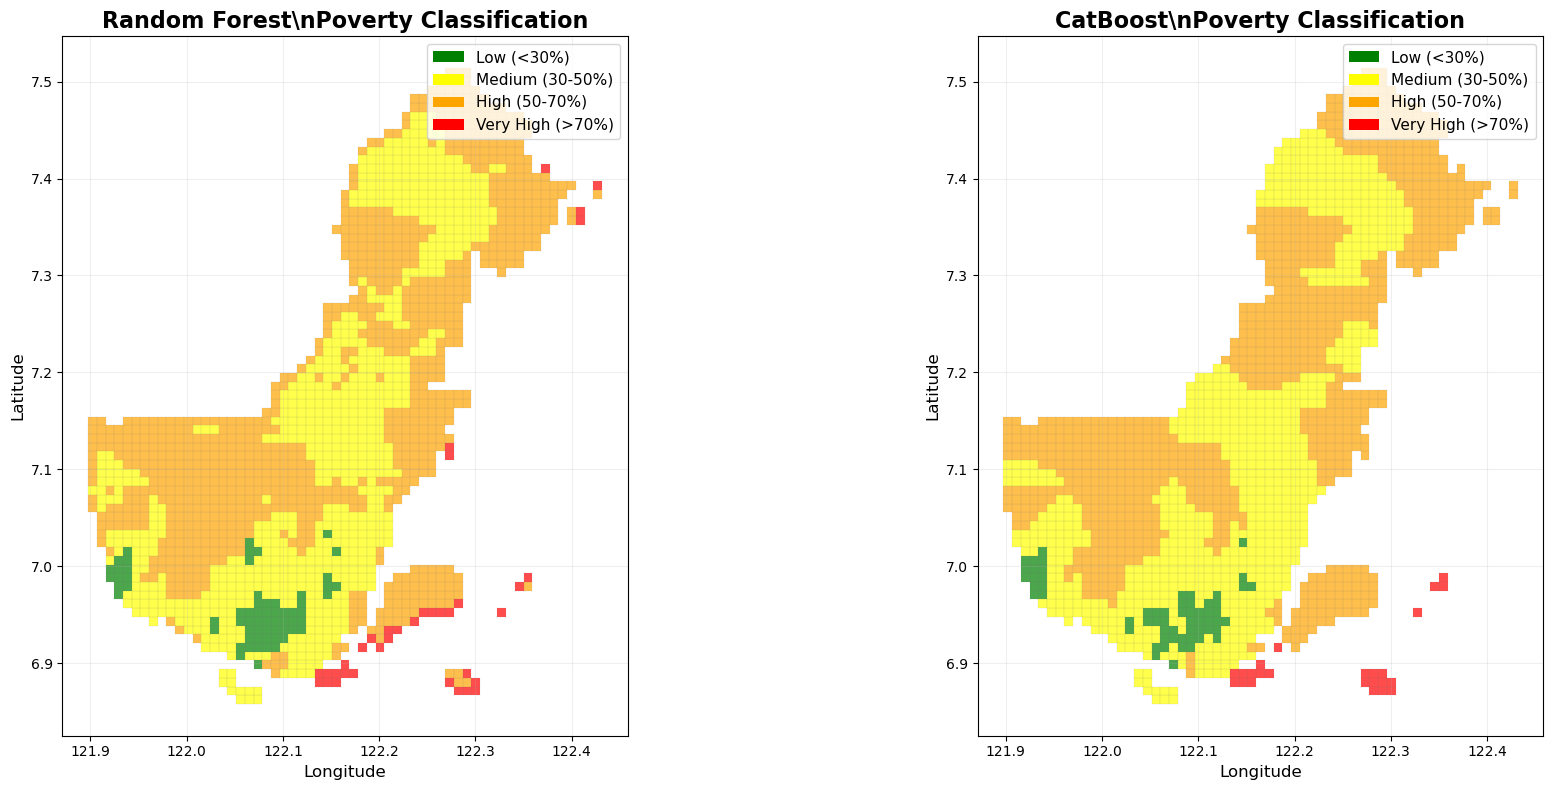


CLASSIFICATION COMPARISON

Random Forest Classification:
  Low (<30%): 65 cells (3.8%)
  Medium (30-50%): 713 cells (41.4%)
  High (50-70%): 910 cells (52.8%)
  Very High (>70%): 36 cells (2.1%)

CatBoost Classification:
  Low (<30%): 61 cells (3.5%)
  Medium (30-50%): 745 cells (43.2%)
  High (50-70%): 894 cells (51.9%)
  Very High (>70%): 24 cells (1.4%)

✓ Classification agreement: 1454 cells (84.3%)

SPATIAL COMPARISON MAPS COMPLETE


In [11]:
if combined is not None:
    import geopandas as gpd
    from matplotlib.patches import Patch
    
    print("\n" + "="*80)
    print("CREATING SPATIAL COMPARISON MAPS")
    print("="*80)
    
    # Load grid geometry
    grid_geojson_path = Path('../assets/grid_with_comprehensive_data.geojson')
    if not grid_geojson_path.exists():
        # Try alternative paths
        alt_paths = [
            Path('../assets/grid_cells.geojson'),
            Path('../assets/grid_with_poverty_predictions.geojson'),
        ]
        for p in alt_paths:
            if p.exists():
                grid_geojson_path = p
                break
    
    if grid_geojson_path.exists():
        print(f"\n✓ Loading grid geometry from {grid_geojson_path}")
        grid_gdf = gpd.read_file(grid_geojson_path)
        
        # Merge with combined predictions
        if 'grid_id' in combined.columns and 'grid_id' in grid_gdf.columns:
            grid_gdf = grid_gdf.merge(
                combined[['grid_id', 'rf_predicted', 'cb_predicted', 'poverty_rate']], 
                on='grid_id', 
                how='left'
            )
        else:
            # Merge by index
            grid_gdf['rf_predicted'] = combined['rf_predicted'].values[:len(grid_gdf)]
            grid_gdf['cb_predicted'] = combined['cb_predicted'].values[:len(grid_gdf)]
            if 'poverty_rate' in combined.columns:
                grid_gdf['poverty_rate'] = combined['poverty_rate'].values[:len(grid_gdf)]
        
        print(f"✓ Merged predictions with {len(grid_gdf)} grid cells")
        
        # ========================================================================
        # MAP SET 1: Predicted Poverty Rates (Side by Side)
        # ========================================================================
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        
        # Map 1: Random Forest Predictions
        ax1 = axes[0]
        grid_gdf.plot(column='rf_predicted', 
                     ax=ax1, 
                     cmap='RdYlGn_r', 
                     legend=True,
                     vmin=0, vmax=1,
                     edgecolor='gray',
                     linewidth=0.1,
                     legend_kwds={'label': 'Predicted Poverty Rate', 'shrink': 0.8})
        
        ax1.set_title('Random Forest\\nPredicted Poverty Rate', 
                     fontsize=16, fontweight='bold')
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        ax1.grid(True, alpha=0.2)
        
        # Map 2: CatBoost Predictions
        ax2 = axes[1]
        grid_gdf.plot(column='cb_predicted', 
                     ax=ax2, 
                     cmap='RdYlGn_r', 
                     legend=True,
                     vmin=0, vmax=1,
                     edgecolor='gray',
                     linewidth=0.1,
                     legend_kwds={'label': 'Predicted Poverty Rate', 'shrink': 0.8})
        
        ax2.set_title('CatBoost\\nPredicted Poverty Rate', 
                     fontsize=16, fontweight='bold')
        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        ax2.grid(True, alpha=0.2)
        
        # Map 3: Prediction Difference (CatBoost - RandomForest)
        ax3 = axes[2]
        grid_gdf['pred_difference'] = grid_gdf['cb_predicted'] - grid_gdf['rf_predicted']
        
        # Use diverging colormap centered at 0
        vmax_diff = max(abs(grid_gdf['pred_difference'].min()), 
                       abs(grid_gdf['pred_difference'].max()))
        
        grid_gdf.plot(column='pred_difference', 
                     ax=ax3, 
                     cmap='RdBu_r', 
                     legend=True,
                     vmin=-vmax_diff, 
                     vmax=vmax_diff,
                     edgecolor='gray',
                     linewidth=0.1,
                     legend_kwds={'label': 'Difference (CB - RF)', 
                                 'shrink': 0.8,
                                 'orientation': 'horizontal'})
        
        ax3.set_title('Prediction Difference\\n(CatBoost - Random Forest)\\nBlue=RF Higher, Red=CB Higher', 
                     fontsize=16, fontweight='bold')
        ax3.set_xlabel('Longitude', fontsize=12)
        ax3.set_ylabel('Latitude', fontsize=12)
        ax3.grid(True, alpha=0.2)
        
        plt.tight_layout()
        plt.savefig(OUTPUT / 'visualizations' / 'spatial_predictions_comparison.png', 
                   dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved to {OUTPUT / 'visualizations' / 'spatial_predictions_comparison.png'}")
        plt.show()
        
        # ========================================================================
        # MAP SET 2: Classification Comparison
        # ========================================================================
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Classify predictions
        grid_gdf['rf_class'] = pd.cut(grid_gdf['rf_predicted'], 
                                      bins=[0, 0.3, 0.5, 0.7, 1.0],
                                      labels=['Low (<30%)', 'Medium (30-50%)', 
                                             'High (50-70%)', 'Very High (>70%)'])
        
        grid_gdf['cb_class'] = pd.cut(grid_gdf['cb_predicted'], 
                                      bins=[0, 0.3, 0.5, 0.7, 1.0],
                                      labels=['Low (<30%)', 'Medium (30-50%)', 
                                             'High (50-70%)', 'Very High (>70%)'])
        
        # Color map
        class_colors = {
            'Low (<30%)': 'green', 
            'Medium (30-50%)': 'yellow', 
            'High (50-70%)': 'orange', 
            'Very High (>70%)': 'red'
        }
        
        # Map 1: Random Forest Classification
        ax1 = axes[0]
        for class_name, color in class_colors.items():
            subset = grid_gdf[grid_gdf['rf_class'] == class_name]
            if len(subset) > 0:
                subset.plot(ax=ax1, color=color, edgecolor='gray', linewidth=0.1, alpha=0.7)
        
        legend_elements = [Patch(facecolor=color, label=label) 
                          for label, color in class_colors.items()]
        ax1.legend(handles=legend_elements, loc='upper right', fontsize=11)
        ax1.set_title('Random Forest\\nPoverty Classification', 
                     fontsize=16, fontweight='bold')
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        ax1.grid(True, alpha=0.2)
        
        # Map 2: CatBoost Classification
        ax2 = axes[1]
        for class_name, color in class_colors.items():
            subset = grid_gdf[grid_gdf['cb_class'] == class_name]
            if len(subset) > 0:
                subset.plot(ax=ax2, color=color, edgecolor='gray', linewidth=0.1, alpha=0.7)
        
        ax2.legend(handles=legend_elements, loc='upper right', fontsize=11)
        ax2.set_title('CatBoost\\nPoverty Classification', 
                     fontsize=16, fontweight='bold')
        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        ax2.grid(True, alpha=0.2)
        
        plt.tight_layout()
        plt.savefig(OUTPUT / 'visualizations' / 'spatial_classification_comparison.png', 
                   dpi=300, bbox_inches='tight')
        print(f"✓ Saved to {OUTPUT / 'visualizations' / 'spatial_classification_comparison.png'}")
        plt.show()
        
        # Print classification statistics
        print("\n" + "="*80)
        print("CLASSIFICATION COMPARISON")
        print("="*80)
        
        print("\nRandom Forest Classification:")
        for class_name in ['Low (<30%)', 'Medium (30-50%)', 'High (50-70%)', 'Very High (>70%)']:
            count = (grid_gdf['rf_class'] == class_name).sum()
            pct = count / len(grid_gdf) * 100
            print(f"  {class_name}: {count} cells ({pct:.1f}%)")
        
        print("\nCatBoost Classification:")
        for class_name in ['Low (<30%)', 'Medium (30-50%)', 'High (50-70%)', 'Very High (>70%)']:
            count = (grid_gdf['cb_class'] == class_name).sum()
            pct = count / len(grid_gdf) * 100
            print(f"  {class_name}: {count} cells ({pct:.1f}%)")
        
        # Classification agreement
        agreement = (grid_gdf['rf_class'] == grid_gdf['cb_class']).sum()
        agreement_pct = agreement / len(grid_gdf) * 100
        print(f"\n✓ Classification agreement: {agreement} cells ({agreement_pct:.1f}%)")
        
        # ========================================================================
        # MAP SET 3: Actual vs Predictions (if actual data available)
        # ========================================================================
        if 'poverty_rate' in grid_gdf.columns:
            training_grid = grid_gdf[grid_gdf['poverty_rate'].notna()].copy()
            
            if len(training_grid) > 0:
                fig, axes = plt.subplots(1, 3, figsize=(24, 8))
                
                # Map 1: Actual Poverty
                ax1 = axes[0]
                training_grid.plot(column='poverty_rate', 
                                  ax=ax1, 
                                  cmap='RdYlGn_r', 
                                  legend=True,
                                  vmin=0, vmax=1,
                                  edgecolor='gray',
                                  linewidth=0.1,
                                  legend_kwds={'label': 'Actual Poverty Rate', 'shrink': 0.8})
                
                ax1.set_title(f'Actual Poverty Rate\\n(Training Cells: {len(training_grid)})', 
                             fontsize=16, fontweight='bold')
                ax1.set_xlabel('Longitude', fontsize=12)
                ax1.set_ylabel('Latitude', fontsize=12)
                ax1.grid(True, alpha=0.2)
                
                # Map 2: RF Predictions (training cells only)
                ax2 = axes[1]
                training_grid.plot(column='rf_predicted', 
                                  ax=ax2, 
                                  cmap='RdYlGn_r', 
                                  legend=True,
                                  vmin=0, vmax=1,
                                  edgecolor='gray',
                                  linewidth=0.1,
                                  legend_kwds={'label': 'RF Predicted', 'shrink': 0.8})
                
                rf_r2 = r2_score(training_grid['poverty_rate'], training_grid['rf_predicted'])
                ax2.set_title(f'Random Forest Predictions\\n(R² = {rf_r2:.4f})', 
                             fontsize=16, fontweight='bold')
                ax2.set_xlabel('Longitude', fontsize=12)
                ax2.set_ylabel('Latitude', fontsize=12)
                ax2.grid(True, alpha=0.2)
                
                # Map 3: CB Predictions (training cells only)
                ax3 = axes[2]
                training_grid.plot(column='cb_predicted', 
                                  ax=ax3, 
                                  cmap='RdYlGn_r', 
                                  legend=True,
                                  vmin=0, vmax=1,
                                  edgecolor='gray',
                                  linewidth=0.1,
                                  legend_kwds={'label': 'CB Predicted', 'shrink': 0.8})
                
                cb_r2 = r2_score(training_grid['poverty_rate'], training_grid['cb_predicted'])
                ax3.set_title(f'CatBoost Predictions\\n(R² = {cb_r2:.4f})', 
                             fontsize=16, fontweight='bold')
                ax3.set_xlabel('Longitude', fontsize=12)
                ax3.set_ylabel('Latitude', fontsize=12)
                ax3.grid(True, alpha=0.2)
                
                plt.tight_layout()
                plt.savefig(OUTPUT / 'visualizations' / 'actual_vs_predictions_spatial.png', 
                           dpi=300, bbox_inches='tight')
                print(f"✓ Saved to {OUTPUT / 'visualizations' / 'actual_vs_predictions_spatial.png'}")
                plt.show()
        
        print("\n" + "="*80)
        print("SPATIAL COMPARISON MAPS COMPLETE")
        print("="*80)
        
    else:
        print(f"\n⚠ Grid GeoJSON file not found at {grid_geojson_path}")
        print("Cannot create spatial comparison maps without geometry data")
else:
    print("\n⚠ Cannot create spatial maps - combined predictions not available")